# Step 0: Generation of MISO-1 with MISO (optional) 
This section is optional since we make MISO-1 available directly. This code for MISO can be used to generate a custom dataset if the user wishes. 
* [X] navigate to `run_scripts/run_controls.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements
* [X] Navigate to the section where it says "MODIFY" and select the scenario (i.e. `partition`) to generate it. Run all 6 scenarios.
* `partition`: 
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies}
* Note: this will generate both the train and test datasets (fairly small dataset size)

# Step 1: Patching MISO-1
* [X] navigate to `run_scripts/run_patch.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements)
* [X] run `sbatch run_scripts/run_patch.sh` for all 6 scenarios (i.e. `cache_name`) and `study_arms` to get patch datasets for training and testing:
* `study_arm`: {train, test, both}
* `cache_name`:
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies}
 * Note: we make the study_arm a parameter here since the number of patches generated is approximately 100K. We realize the number of items in filesystems can be maxed out (as opposed to actual storage), so we recommmend toggle this as needed while you train models on specific parititons, delete patch datasets of no use, and generate more as needed

# Step 2: Training 
* [X] navigate to `run_scripts/run_train.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements)
* [X] run `sbatch run_scripts/run_train.sh` for all 12 models (2 architectures [i.e. `model_class`] x 6 scenarios): 
* `model_class`: {VGG19, VGG_att}
* `scenario`:
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies}

# Step 3: Prediction
* [X] navigate to `run_scripts/run_predict_saliency.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements)
* [X] run `run_scripts/run_predict_saliency.sh` for all 12 models (2 architectures [i.e. `model`] x 6 scenarios): 
* `model`: {VGG19, VGG_att}
* `scenario`:
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies}


# Step 4: Explanation evaluation via Prediction Report Cards
After all the above jobs are run, we can generate performance statistics and take a look at local explanations that are illustrative of average test set performance.

### Setup for model performance and interpretation

In [1]:
import pickle
import utils
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.signal import medfilt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from dataloader import DataLoader
from train import Flatten

from utils import serialize, deserialize, count_files #image_patch_summary, image_patch_pred_map, plot_roc_prc # should probably move serialize and de- to utils
from saliency import create_prediction_reportcard # show_saliency_maps, stitch_saliency, 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()
%reload_ext autoreload

In [3]:
USE_GPU = False
dtype = torch.float32    

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
patch_root = "/oak/stanford/groups/paragm/gautam/syncontrols/patches/1-channel"
patch_tail = "96-patchsize/background-filtered/train"
figure_path = "figs" # make sure you create a "figs" folder

### Report Card helper functions

In [5]:
def print_train_stats(scenario_str):
    label_dict_train = "outputs/train-controls-" + scenario_str + "-96-background-labeldict.obj"
    ld_train = utils.deserialize(label_dict_train)
    print("Train dataset\n"+"="*50)
    print(ld_train)
    print("# patches:", utils.count_files(patch_root + "/" + scenario_str + "/" + patch_tail))

In [6]:
def report_card(scenario, model, example_1, example_0, fig_path=figure_path, filter_toggle="background", reduce_flag=False):
    specs = "-stored_random_loading-96-label_inherit-bce_loss-on_controls-" + scenario + "-filtration_" + filter_toggle + "_full"
    folder = "outputs/"
    label_path = folder + "test-controls-" + scenario + "-96-background-labeldict.obj"
    img_path = "/oak/stanford/groups/paragm/gautam/syncontrols/1-channel/" + scenario + "/test"
    ppmgt_path = folder + "controls-" + scenario + "-96-background-ppmgts.obj"
    model_name_list = [model]
    model_predpath_list = [folder + model + specs + "_preddict.obj"]
    
    create_prediction_reportcard(scenario, specs, folder, label_path, img_path, ppmgt_path, model_name_list, model_predpath_list, example_1, example_0, fig_path, num_examples=1, reduce_flag=reduce_flag)

# Scenario (a) - Extreme Value Pixels (EVP)

### Background-filtered experiments

`Check training labels`

In [7]:
scenario = "extreme_value_pixels"
print_train_stats(scenario)

Train dataset
{'reg57': 1, 'reg85': 1, 'reg25': 1, 'reg36': 0, 'reg12': 0, 'reg23': 1, 'reg5': 1, 'reg3': 1, 'reg72': 0, 'reg70': 0, 'reg2': 0, 'reg41': 1, 'reg71': 1, 'reg28': 0, 'reg52': 0, 'reg19': 1, 'reg43': 1, 'reg91': 1, 'reg60': 0, 'reg59': 1, 'reg78': 0, 'reg21': 1, 'reg30': 0, 'reg17': 1, 'reg9': 1, 'reg7': 1, 'reg10': 0, 'reg34': 0, 'reg58': 0, 'reg42': 0, 'reg87': 1, 'reg83': 1, 'reg51': 1, 'reg75': 1, 'reg49': 1, 'reg63': 1, 'reg79': 1, 'reg54': 0, 'reg50': 0, 'reg6': 0, 'reg27': 1, 'reg33': 1, 'reg32': 0, 'reg62': 0, 'reg81': 1, 'reg96': 0, 'reg64': 0, 'reg61': 1, 'reg35': 1, 'reg56': 0, 'reg77': 1, 'reg31': 1, 'reg93': 1, 'reg11': 1, 'reg53': 1, 'reg39': 1, 'reg26': 0, 'reg1': 1, 'reg88': 0, 'reg45': 1, 'reg80': 0, 'reg16': 0, 'reg37': 1, 'reg92': 0, 'reg13': 1, 'reg48': 0, 'reg68': 0, 'reg14': 0, 'reg66': 0, 'reg76': 0, 'reg22': 0, 'reg47': 1, 'reg94': 0, 'reg46': 0, 'reg29': 1, 'reg24': 0, 'reg67': 1, 'reg18': 0, 'reg84': 0, 'reg86': 0, 'reg38': 0, 'reg90': 0, 'reg44':

`VGG-19 Report Card`

Test dataset:
{'reg42': 0, 'reg53': 1, 'reg69': 1, 'reg76': 0, 'reg40': 0, 'reg18': 0, 'reg78': 0, 'reg12': 0, 'reg72': 0, 'reg87': 1, 'reg52': 0, 'reg23': 1, 'reg44': 0, 'reg11': 1, 'reg29': 1, 'reg63': 1, 'reg21': 1, 'reg10': 0, 'reg26': 0, 'reg59': 1, 'reg90': 0, 'reg36': 0, 'reg58': 0, 'reg94': 0, 'reg68': 0, 'reg79': 1, 'reg80': 0, 'reg43': 1, 'reg57': 1, 'reg25': 1, 'reg27': 1, 'reg83': 1, 'reg17': 1, 'reg74': 0, 'reg91': 1, 'reg39': 1, 'reg4': 0, 'reg50': 0, 'reg81': 1, 'reg64': 0, 'reg22': 0, 'reg15': 1, 'reg35': 1, 'reg86': 0, 'reg51': 1, 'reg82': 0, 'reg48': 0, 'reg93': 1, 'reg88': 0, 'reg46': 0, 'reg55': 1, 'reg2': 0, 'reg77': 1, 'reg71': 1, 'reg9': 1, 'reg13': 1, 'reg32': 0, 'reg65': 1, 'reg84': 0, 'reg47': 1, 'reg6': 0, 'reg60': 0, 'reg66': 0, 'reg56': 0, 'reg16': 0, 'reg38': 0, 'reg73': 1, 'reg31': 1, 'reg95': 1, 'reg5': 1, 'reg19': 1, 'reg24': 0, 'reg30': 0, 'reg75': 1, 'reg37': 1, 'reg67': 1, 'reg20': 0, 'reg92': 0, 'reg28': 0, 'reg54': 0, 'reg1': 1, 'reg70': 0, 'reg89'

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 2 reg69 label= 1
raw gt: [[ 0.44851345  0.44851345  0.44976128 ... -0.5        -0.5
   0.        ]
 [ 0.44851345  0.89702691  0.89827474 ... -1.         -1.
  -0.5       ]
 [ 0.45068359  0.89919705  0.8999566  ... -1.         -1.
  -0.5       ]
 ...
 [-0.5        -1.         -1.         ... -1.         -1.
  -0.5       ]
 [-0.5        -1.         -1.         ... -1.         -1.
  -0.5       ]
 [ 0.         -0.5        -0.5        ... -0.5        -0.5
  -0.5       ]]
preview of maps
raw sal: [[0.00404632 0.00404632 0.0040422  ... 0.         0.         0.        ]
 [0.00404632 0.00809263 0.00808852 ... 0.         0.         0.        ]
 [0.00404092 0.00808724 0.00808992 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
bin sal: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ...

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 45 reg82 label= 0
	 46 reg48 label= 0
	 47 reg93 label= 1
	 48 reg88 label= 0
	 49 reg46 label= 0
	 50 reg55 label= 1
	Completed analyses for 50 control images
	 51 reg2 label= 0
	 52 reg77 label= 1
	 53 reg71 label= 1
	 54 reg9 label= 1
	 55 reg13 label= 1
	 56 reg32 label= 0
	 57 reg65 label= 1
	 58 reg84 label= 0
	 59 reg47 label= 1
	 60 reg6 label= 0
	Completed analyses for 60 control images
	 61 reg60 label= 0
	 62 reg66 label= 0
	 63 reg56 label= 0
	 64 reg16 label= 0
	 65 reg38 label= 0
	 66 reg73 label= 1
	 67 reg31 label= 1
	 68 reg95 label= 1
	 69 reg5 label= 1
	 70 reg19 label= 1
	Completed analyses for 70 control images
	 71 reg24 label= 0
	 72 reg30 label= 0
	 73 reg75 label= 1
	 74 reg37 label= 1
	 75 reg67 label= 1
	 76 reg20 label= 0
	 77 reg92 label= 0
	 78 reg28 label= 0
	 79 reg54 label= 0
	 80 reg1 label= 1
	Completed analyses for 80 control images
	 81 reg70 label= 0
	 82 reg89 label= 1
	 83 reg41 label= 1
	 84 reg34 label= 0
	 85 reg14 label= 0
	 86 reg61 label=

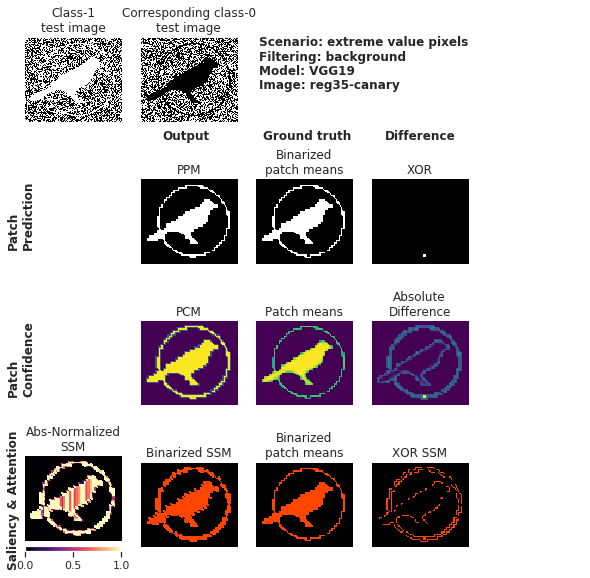

In [8]:
model = "VGG19"
example_1 = "reg35-canary-hot-test.npy" 
example_0 = "reg36-canary-cold-test.npy" 
report_card(scenario, model, example_1, example_0)

`VGG-Att Report Card`

Test dataset:
{'reg42': 0, 'reg53': 1, 'reg69': 1, 'reg76': 0, 'reg40': 0, 'reg18': 0, 'reg78': 0, 'reg12': 0, 'reg72': 0, 'reg87': 1, 'reg52': 0, 'reg23': 1, 'reg44': 0, 'reg11': 1, 'reg29': 1, 'reg63': 1, 'reg21': 1, 'reg10': 0, 'reg26': 0, 'reg59': 1, 'reg90': 0, 'reg36': 0, 'reg58': 0, 'reg94': 0, 'reg68': 0, 'reg79': 1, 'reg80': 0, 'reg43': 1, 'reg57': 1, 'reg25': 1, 'reg27': 1, 'reg83': 1, 'reg17': 1, 'reg74': 0, 'reg91': 1, 'reg39': 1, 'reg4': 0, 'reg50': 0, 'reg81': 1, 'reg64': 0, 'reg22': 0, 'reg15': 1, 'reg35': 1, 'reg86': 0, 'reg51': 1, 'reg82': 0, 'reg48': 0, 'reg93': 1, 'reg88': 0, 'reg46': 0, 'reg55': 1, 'reg2': 0, 'reg77': 1, 'reg71': 1, 'reg9': 1, 'reg13': 1, 'reg32': 0, 'reg65': 1, 'reg84': 0, 'reg47': 1, 'reg6': 0, 'reg60': 0, 'reg66': 0, 'reg56': 0, 'reg16': 0, 'reg38': 0, 'reg73': 1, 'reg31': 1, 'reg95': 1, 'reg5': 1, 'reg19': 1, 'reg24': 0, 'reg30': 0, 'reg75': 1, 'reg37': 1, 'reg67': 1, 'reg20': 0, 'reg92': 0, 'reg28': 0, 'reg54': 0, 'reg1': 1, 'reg70': 0, 'reg89'

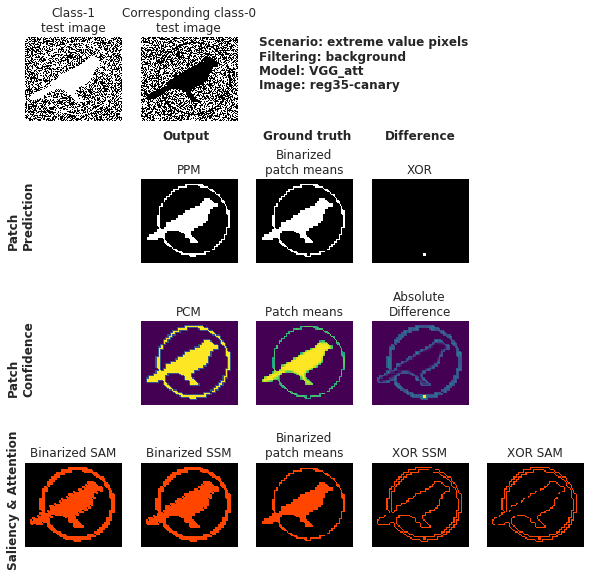

In [9]:
model = "VGG_att"
example_1 = "reg35-canary-hot-test.npy" 
example_0 = "reg36-canary-cold-test.npy"
report_card(scenario, model, example_1, example_0)

# Scenario (b) - Distribution-Shifted Pixels (DSP)

### Background-filtered experiments

`Check training labels`

In [10]:
scenario = "distribution_shifted_pixels"
print_train_stats(scenario)

Train dataset
{'reg32': 0, 'reg55': 1, 'reg26': 0, 'reg3': 1, 'reg53': 1, 'reg23': 1, 'reg30': 0, 'reg33': 1, 'reg67': 1, 'reg83': 1, 'reg88': 0, 'reg36': 0, 'reg29': 1, 'reg94': 0, 'reg14': 0, 'reg7': 1, 'reg40': 0, 'reg8': 0, 'reg61': 1, 'reg72': 0, 'reg68': 0, 'reg82': 0, 'reg79': 1, 'reg96': 0, 'reg6': 0, 'reg48': 0, 'reg49': 1, 'reg86': 0, 'reg92': 0, 'reg89': 1, 'reg54': 0, 'reg71': 1, 'reg46': 0, 'reg37': 1, 'reg60': 0, 'reg10': 0, 'reg13': 1, 'reg73': 1, 'reg74': 0, 'reg25': 1, 'reg4': 0, 'reg91': 1, 'reg9': 1, 'reg65': 1, 'reg42': 0, 'reg35': 1, 'reg21': 1, 'reg52': 0, 'reg12': 0, 'reg56': 0, 'reg50': 0, 'reg11': 1, 'reg93': 1, 'reg59': 1, 'reg85': 1, 'reg34': 0, 'reg87': 1, 'reg5': 1, 'reg39': 1, 'reg43': 1, 'reg84': 0, 'reg28': 0, 'reg64': 0, 'reg75': 1, 'reg27': 1, 'reg80': 0, 'reg22': 0, 'reg44': 0, 'reg63': 1, 'reg51': 1, 'reg57': 1, 'reg90': 0, 'reg95': 1, 'reg76': 0, 'reg70': 0, 'reg66': 0, 'reg81': 1, 'reg16': 0, 'reg69': 1, 'reg20': 0, 'reg38': 0, 'reg17': 1, 'reg31':

`VGG-19 Report Card`

Test dataset:
{'reg11': 1, 'reg64': 0, 'reg53': 1, 'reg68': 0, 'reg30': 0, 'reg9': 1, 'reg39': 1, 'reg22': 0, 'reg1': 1, 'reg76': 0, 'reg42': 0, 'reg24': 0, 'reg41': 1, 'reg58': 0, 'reg10': 0, 'reg34': 0, 'reg12': 0, 'reg78': 0, 'reg66': 0, 'reg52': 0, 'reg31': 1, 'reg3': 1, 'reg60': 0, 'reg71': 1, 'reg74': 0, 'reg57': 1, 'reg19': 1, 'reg14': 0, 'reg8': 0, 'reg47': 1, 'reg2': 0, 'reg69': 1, 'reg28': 0, 'reg13': 1, 'reg70': 0, 'reg5': 1, 'reg87': 1, 'reg83': 1, 'reg81': 1, 'reg38': 0, 'reg35': 1, 'reg92': 0, 'reg21': 1, 'reg32': 0, 'reg16': 0, 'reg79': 1, 'reg89': 1, 'reg56': 0, 'reg43': 1, 'reg94': 0, 'reg85': 1, 'reg72': 0, 'reg20': 0, 'reg18': 0, 'reg80': 0, 'reg50': 0, 'reg27': 1, 'reg49': 1, 'reg88': 0, 'reg67': 1, 'reg44': 0, 'reg15': 1, 'reg46': 0, 'reg7': 1, 'reg65': 1, 'reg90': 0, 'reg82': 0, 'reg55': 1, 'reg59': 1, 'reg84': 0, 'reg4': 0, 'reg54': 0, 'reg40': 0, 'reg29': 1, 'reg93': 1, 'reg23': 1, 'reg26': 0, 'reg33': 1, 'reg17': 1, 'reg91': 1, 'reg61': 1, 'reg6': 0, 'reg45': 1

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 39 reg38 label= 0
	 40 reg35 label= 1
	Completed analyses for 40 control images
	 41 reg92 label= 0
	 42 reg21 label= 1
	 43 reg32 label= 0
	 44 reg16 label= 0
	 45 reg79 label= 1
	 46 reg89 label= 1
	 47 reg56 label= 0
	 48 reg43 label= 1
	 49 reg94 label= 0
	 50 reg85 label= 1
	Completed analyses for 50 control images
	 51 reg72 label= 0
	 52 reg20 label= 0
	 53 reg18 label= 0
	 54 reg80 label= 0
	 55 reg50 label= 0
	 56 reg27 label= 1
	 57 reg49 label= 1
	 58 reg88 label= 0
	 59 reg67 label= 1
	 60 reg44 label= 0
	Completed analyses for 60 control images
	 61 reg15 label= 1
	 62 reg46 label= 0
	 63 reg7 label= 1
	 64 reg65 label= 1
	 65 reg90 label= 0
	 66 reg82 label= 0
	 67 reg55 label= 1
	 68 reg59 label= 1
	 69 reg84 label= 0
	 70 reg4 label= 0
	Completed analyses for 70 control images
	 71 reg54 label= 0
	 72 reg40 label= 0
	 73 reg29 label= 1
	 74 reg93 label= 1
	 75 reg23 label= 1
	 76 reg26 label= 0
	 77 reg33 label= 1
	 78 reg17 label= 1
	 79 reg91 label= 1
	 80 reg61 lab

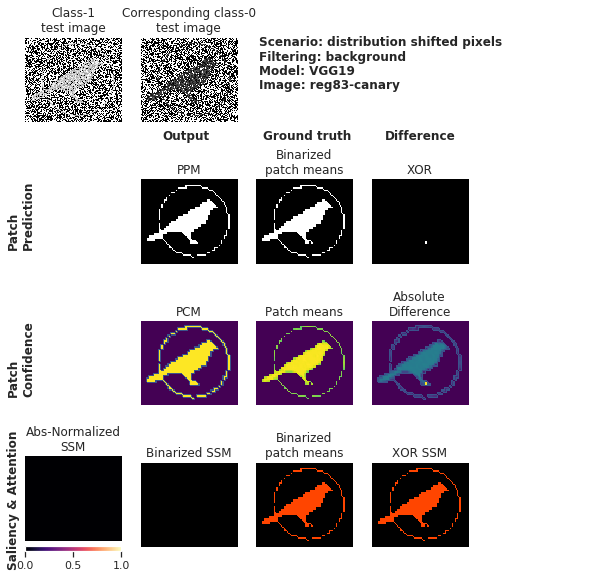

In [11]:
model = "VGG19"
example_1 = "reg83-canary-fuzzy_distrib-hot-test.npy" 
example_0 = "reg84-canary-fuzzy_distrib-cold-test.npy" 
report_card(scenario, model, example_1, example_0)

`VGG-Att Report Card`

Test dataset:
{'reg11': 1, 'reg64': 0, 'reg53': 1, 'reg68': 0, 'reg30': 0, 'reg9': 1, 'reg39': 1, 'reg22': 0, 'reg1': 1, 'reg76': 0, 'reg42': 0, 'reg24': 0, 'reg41': 1, 'reg58': 0, 'reg10': 0, 'reg34': 0, 'reg12': 0, 'reg78': 0, 'reg66': 0, 'reg52': 0, 'reg31': 1, 'reg3': 1, 'reg60': 0, 'reg71': 1, 'reg74': 0, 'reg57': 1, 'reg19': 1, 'reg14': 0, 'reg8': 0, 'reg47': 1, 'reg2': 0, 'reg69': 1, 'reg28': 0, 'reg13': 1, 'reg70': 0, 'reg5': 1, 'reg87': 1, 'reg83': 1, 'reg81': 1, 'reg38': 0, 'reg35': 1, 'reg92': 0, 'reg21': 1, 'reg32': 0, 'reg16': 0, 'reg79': 1, 'reg89': 1, 'reg56': 0, 'reg43': 1, 'reg94': 0, 'reg85': 1, 'reg72': 0, 'reg20': 0, 'reg18': 0, 'reg80': 0, 'reg50': 0, 'reg27': 1, 'reg49': 1, 'reg88': 0, 'reg67': 1, 'reg44': 0, 'reg15': 1, 'reg46': 0, 'reg7': 1, 'reg65': 1, 'reg90': 0, 'reg82': 0, 'reg55': 1, 'reg59': 1, 'reg84': 0, 'reg4': 0, 'reg54': 0, 'reg40': 0, 'reg29': 1, 'reg93': 1, 'reg23': 1, 'reg26': 0, 'reg33': 1, 'reg17': 1, 'reg91': 1, 'reg61': 1, 'reg6': 0, 'reg45': 1

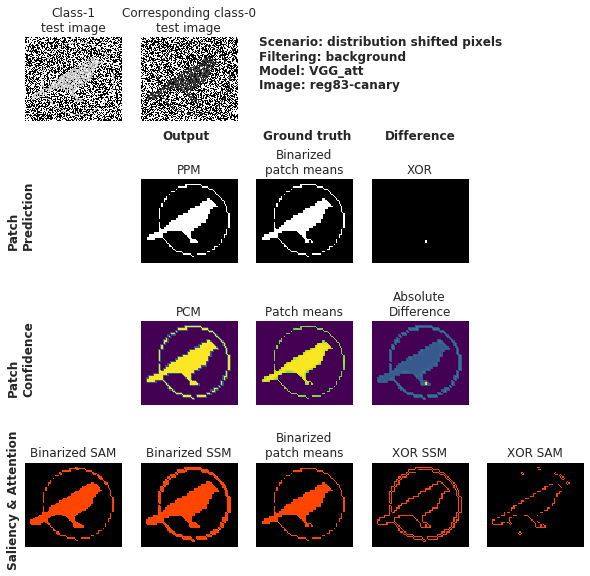

In [12]:
model = "VGG_att"
example_1 = "reg83-canary-fuzzy_distrib-hot-test.npy" 
example_0 = "reg84-canary-fuzzy_distrib-cold-test.npy" 
report_card(scenario, model, example_1, example_0, reduce_flag="manual")

# Scenario (c) - Morphological Differences (MD)

### Background-filtered experiments

`Check training labels`

In [13]:
scenario = "morphological_differences"
print_train_stats(scenario)

Train dataset
{'reg42': 0, 'reg6': 0, 'reg100': 1, 'reg49': 0, 'reg86': 1, 'reg12': 0, 'reg57': 1, 'reg34': 0, 'reg5': 0, 'reg27': 0, 'reg102': 1, 'reg84': 1, 'reg39': 0, 'reg75': 1, 'reg51': 0, 'reg87': 1, 'reg80': 1, 'reg68': 1, 'reg47': 0, 'reg61': 1, 'reg82': 1, 'reg59': 1, 'reg79': 1, 'reg37': 0, 'reg64': 1, 'reg16': 0, 'reg70': 1, 'reg112': 1, 'reg21': 0, 'reg38': 0, 'reg40': 0, 'reg19': 0, 'reg85': 1, 'reg76': 1, 'reg26': 0, 'reg90': 1, 'reg99': 1, 'reg103': 1, 'reg24': 0, 'reg92': 1, 'reg50': 0, 'reg101': 1, 'reg43': 0, 'reg31': 0, 'reg58': 1, 'reg1': 0, 'reg10': 0, 'reg44': 0, 'reg13': 0, 'reg63': 1, 'reg89': 1, 'reg97': 1, 'reg48': 0, 'reg111': 1, 'reg69': 1, 'reg35': 0, 'reg105': 1, 'reg83': 1, 'reg11': 0, 'reg94': 1, 'reg55': 0, 'reg77': 1, 'reg29': 0, 'reg107': 1, 'reg96': 1, 'reg36': 0, 'reg88': 1, 'reg33': 0, 'reg109': 1, 'reg67': 1, 'reg71': 1, 'reg18': 0, 'reg52': 0, 'reg66': 1, 'reg104': 1, 'reg110': 1, 'reg54': 0, 'reg15': 0, 'reg93': 1, 'reg53': 0, 'reg23': 0, 'reg1

`VGG-19 Report Card`

Test dataset:
{'reg89': 1, 'reg109': 1, 'reg39': 0, 'reg68': 1, 'reg93': 1, 'reg81': 1, 'reg46': 0, 'reg36': 0, 'reg56': 0, 'reg91': 1, 'reg57': 1, 'reg38': 0, 'reg106': 1, 'reg22': 0, 'reg48': 0, 'reg65': 1, 'reg41': 0, 'reg21': 0, 'reg84': 1, 'reg72': 1, 'reg90': 1, 'reg70': 1, 'reg27': 0, 'reg108': 1, 'reg99': 1, 'reg103': 1, 'reg51': 0, 'reg52': 0, 'reg77': 1, 'reg14': 0, 'reg64': 1, 'reg49': 0, 'reg19': 0, 'reg31': 0, 'reg17': 0, 'reg67': 1, 'reg5': 0, 'reg85': 1, 'reg104': 1, 'reg53': 0, 'reg34': 0, 'reg28': 0, 'reg25': 0, 'reg15': 0, 'reg33': 0, 'reg42': 0, 'reg26': 0, 'reg45': 0, 'reg86': 1, 'reg95': 1, 'reg16': 0, 'reg8': 0, 'reg3': 0, 'reg73': 1, 'reg98': 1, 'reg92': 1, 'reg58': 1, 'reg75': 1, 'reg78': 1, 'reg60': 1, 'reg35': 0, 'reg24': 0, 'reg44': 0, 'reg7': 0, 'reg40': 0, 'reg61': 1, 'reg76': 1, 'reg107': 1, 'reg80': 1, 'reg87': 1, 'reg55': 0, 'reg30': 0, 'reg97': 1, 'reg11': 0, 'reg74': 1, 'reg37': 0, 'reg105': 1, 'reg79': 1, 'reg1': 0, 'reg29': 0, 'reg13': 0, 'reg20': 0,

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 60 reg35 label= 0
	Completed analyses for 60 control images
	 61 reg24 label= 0
	 62 reg44 label= 0
	 63 reg7 label= 0
	 64 reg40 label= 0
	 65 reg61 label= 1
	 66 reg76 label= 1
	 67 reg107 label= 1
	 68 reg80 label= 1
	 69 reg87 label= 1
	 70 reg55 label= 0
	Completed analyses for 70 control images
	 71 reg30 label= 0
	 72 reg97 label= 1
	 73 reg11 label= 0
	 74 reg74 label= 1
	 75 reg37 label= 0
	 76 reg105 label= 1
	 77 reg79 label= 1
	 78 reg1 label= 0
	 79 reg29 label= 0
	 80 reg13 label= 0
	Completed analyses for 80 control images
	 81 reg20 label= 0
	 82 reg100 label= 1
	 83 reg88 label= 1
	 84 reg110 label= 1
	 85 reg18 label= 0
	 86 reg2 label= 0
	 87 reg71 label= 1
	 88 reg54 label= 0
	 89 reg66 label= 1
	 90 reg83 label= 1
	Completed analyses for 90 control images
	 91 reg32 label= 0
	 92 reg10 label= 0
	 93 reg47 label= 0
	 94 reg102 label= 1
	 95 reg9 label= 0
	 96 reg62 label= 1
	 97 reg112 label= 1
	 98 reg4 label= 0
	 99 reg59 label= 1
	 100 reg94 label= 1
	Completed

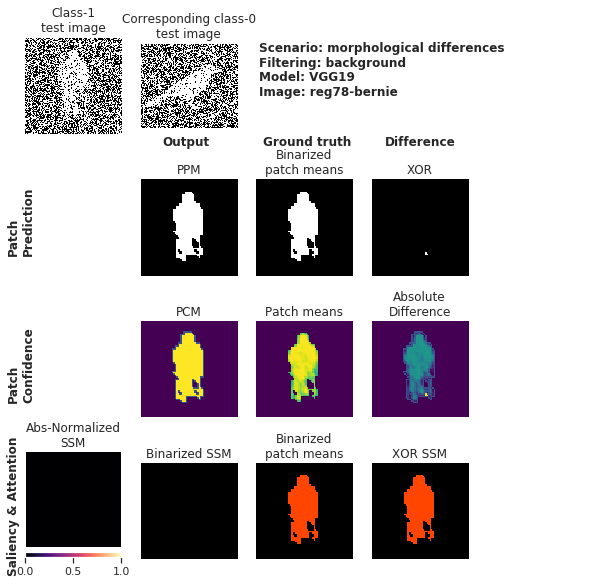

In [14]:
model = "VGG19"
example_1 = "reg78-bernie-etsy-fuzzy-hot-test.npy"
example_0 = "reg44-canary-fuzzy-hot-test.npy"
report_card(scenario, model, example_1, example_0)

`VGG-Att Report Card` (Run kills kernel easily on jupyter -- adding manual removal)

Test dataset:
{'reg89': 1, 'reg109': 1, 'reg39': 0, 'reg68': 1, 'reg93': 1, 'reg81': 1, 'reg46': 0, 'reg36': 0, 'reg56': 0, 'reg91': 1, 'reg57': 1, 'reg38': 0, 'reg106': 1, 'reg22': 0, 'reg48': 0, 'reg65': 1, 'reg41': 0, 'reg21': 0, 'reg84': 1, 'reg72': 1, 'reg90': 1, 'reg70': 1, 'reg27': 0, 'reg108': 1, 'reg99': 1, 'reg103': 1, 'reg51': 0, 'reg52': 0, 'reg77': 1, 'reg14': 0, 'reg64': 1, 'reg49': 0, 'reg19': 0, 'reg31': 0, 'reg17': 0, 'reg67': 1, 'reg5': 0, 'reg85': 1, 'reg104': 1, 'reg53': 0, 'reg34': 0, 'reg28': 0, 'reg25': 0, 'reg15': 0, 'reg33': 0, 'reg42': 0, 'reg26': 0, 'reg45': 0, 'reg86': 1, 'reg95': 1, 'reg16': 0, 'reg8': 0, 'reg3': 0, 'reg73': 1, 'reg98': 1, 'reg92': 1, 'reg58': 1, 'reg75': 1, 'reg78': 1, 'reg60': 1, 'reg35': 0, 'reg24': 0, 'reg44': 0, 'reg7': 0, 'reg40': 0, 'reg61': 1, 'reg76': 1, 'reg107': 1, 'reg80': 1, 'reg87': 1, 'reg55': 0, 'reg30': 0, 'reg97': 1, 'reg11': 0, 'reg74': 1, 'reg37': 0, 'reg105': 1, 'reg79': 1, 'reg1': 0, 'reg29': 0, 'reg13': 0, 'reg20': 0,

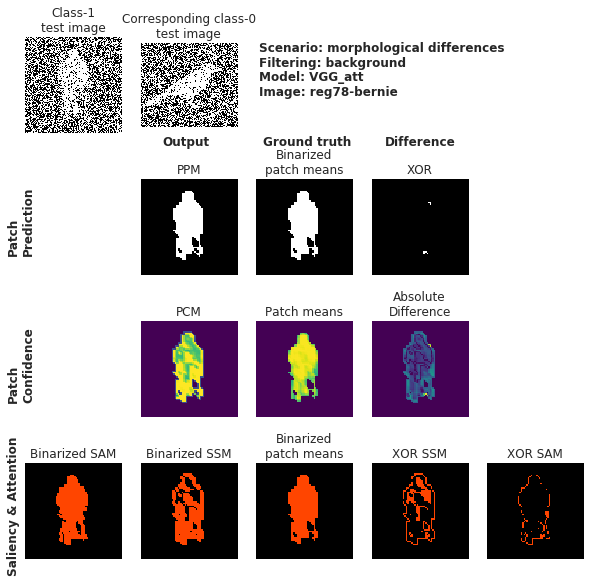

In [15]:
model = "VGG_att"
example_1 = "reg78-bernie-etsy-fuzzy-hot-test.npy"
example_0 = "reg44-canary-fuzzy-hot-test.npy"
report_card(scenario, model, example_1, example_0, reduce_flag="manual")

# Scenario (d) - Extreme Value Superpixels (EVSP)

### Background-filtered experiments

`Check training labels`

In [16]:
scenario = "extreme_value_superpixels"
print_train_stats(scenario)

Train dataset
{'reg9': 1, 'reg95': 1, 'reg37': 1, 'reg69': 1, 'reg47': 1, 'reg81': 1, 'reg27': 1, 'reg78': 0, 'reg38': 0, 'reg43': 1, 'reg92': 0, 'reg82': 0, 'reg58': 0, 'reg20': 0, 'reg46': 0, 'reg15': 1, 'reg5': 1, 'reg63': 1, 'reg91': 1, 'reg79': 1, 'reg2': 0, 'reg44': 0, 'reg72': 0, 'reg6': 0, 'reg30': 0, 'reg68': 0, 'reg49': 1, 'reg25': 1, 'reg36': 0, 'reg87': 1, 'reg14': 0, 'reg59': 1, 'reg61': 1, 'reg60': 0, 'reg96': 0, 'reg24': 0, 'reg71': 1, 'reg19': 1, 'reg31': 1, 'reg54': 0, 'reg76': 0, 'reg62': 0, 'reg55': 1, 'reg28': 0, 'reg34': 0, 'reg73': 1, 'reg18': 0, 'reg80': 0, 'reg65': 1, 'reg13': 1, 'reg41': 1, 'reg56': 0, 'reg11': 1, 'reg93': 1, 'reg64': 0, 'reg21': 1, 'reg88': 0, 'reg16': 0, 'reg40': 0, 'reg51': 1, 'reg67': 1, 'reg39': 1, 'reg17': 1, 'reg8': 0, 'reg94': 0, 'reg66': 0, 'reg3': 1, 'reg89': 1, 'reg50': 0, 'reg22': 0, 'reg23': 1, 'reg90': 0, 'reg26': 0, 'reg45': 1, 'reg32': 0, 'reg74': 0, 'reg10': 0, 'reg12': 0, 'reg84': 0, 'reg1': 1, 'reg85': 1, 'reg29': 1, 'reg52':

`VGG-19 Report Card`

Test dataset:
{'reg11': 1, 'reg32': 0, 'reg84': 0, 'reg96': 0, 'reg36': 0, 'reg33': 1, 'reg14': 0, 'reg49': 1, 'reg71': 1, 'reg68': 0, 'reg81': 1, 'reg90': 0, 'reg56': 0, 'reg1': 1, 'reg78': 0, 'reg6': 0, 'reg45': 1, 'reg53': 1, 'reg80': 0, 'reg57': 1, 'reg76': 0, 'reg19': 1, 'reg13': 1, 'reg23': 1, 'reg41': 1, 'reg63': 1, 'reg85': 1, 'reg9': 1, 'reg17': 1, 'reg28': 0, 'reg30': 0, 'reg72': 0, 'reg54': 0, 'reg12': 0, 'reg73': 1, 'reg37': 1, 'reg74': 0, 'reg16': 0, 'reg87': 1, 'reg10': 0, 'reg44': 0, 'reg15': 1, 'reg65': 1, 'reg35': 1, 'reg40': 0, 'reg77': 1, 'reg48': 0, 'reg88': 0, 'reg64': 0, 'reg34': 0, 'reg94': 0, 'reg83': 1, 'reg55': 1, 'reg26': 0, 'reg51': 1, 'reg91': 1, 'reg8': 0, 'reg18': 0, 'reg79': 1, 'reg24': 0, 'reg70': 0, 'reg61': 1, 'reg3': 1, 'reg86': 0, 'reg43': 1, 'reg22': 0, 'reg50': 0, 'reg2': 0, 'reg25': 1, 'reg95': 1, 'reg46': 0, 'reg39': 1, 'reg69': 1, 'reg38': 0, 'reg21': 1, 'reg42': 0, 'reg58': 0, 'reg75': 1, 'reg89': 1, 'reg5': 1, 'reg7': 1, 'reg27': 1, 'reg92': 

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 75 reg42 label= 0
	 76 reg58 label= 0
	 77 reg75 label= 1
	 78 reg89 label= 1
	 79 reg5 label= 1
	 80 reg7 label= 1
	Completed analyses for 80 control images
	 81 reg27 label= 1
	 82 reg92 label= 0
	 83 reg66 label= 0
	 84 reg29 label= 1
	 85 reg82 label= 0
	 86 reg60 label= 0
	 87 reg20 label= 0
	 88 reg4 label= 0
	 89 reg47 label= 1
	 90 reg31 label= 1
	Completed analyses for 90 control images
	 91 reg62 label= 0
	 92 reg93 label= 1
	 93 reg59 label= 1
	 94 reg52 label= 0
	 95 reg67 label= 1
	Finalizing average: dice (n=48 measurements)
		 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	Finalizing average: jaccard (n=48 measurements)
		 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

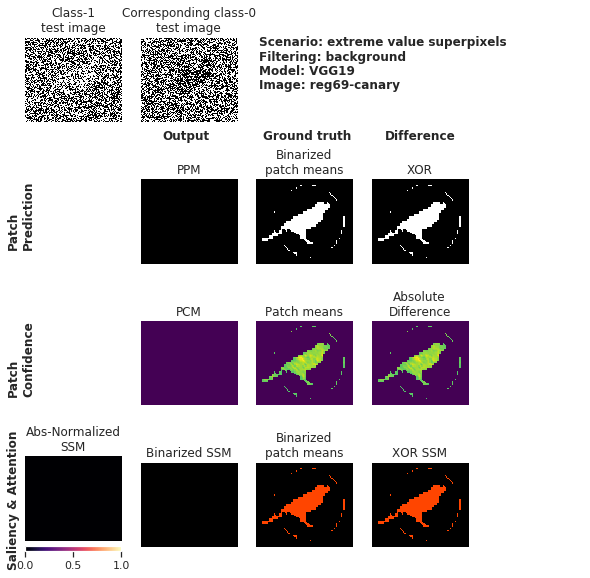

In [17]:
model = "VGG19"
example_1 = "reg69-canary-hot-test_superpixels.npy"
example_0 = "reg70-canary-cold-test_superpixels.npy"
report_card(scenario, model, example_1, example_0)

Test dataset:
{'reg11': 1, 'reg32': 0, 'reg84': 0, 'reg96': 0, 'reg36': 0, 'reg33': 1, 'reg14': 0, 'reg49': 1, 'reg71': 1, 'reg68': 0, 'reg81': 1, 'reg90': 0, 'reg56': 0, 'reg1': 1, 'reg78': 0, 'reg6': 0, 'reg45': 1, 'reg53': 1, 'reg80': 0, 'reg57': 1, 'reg76': 0, 'reg19': 1, 'reg13': 1, 'reg23': 1, 'reg41': 1, 'reg63': 1, 'reg85': 1, 'reg9': 1, 'reg17': 1, 'reg28': 0, 'reg30': 0, 'reg72': 0, 'reg54': 0, 'reg12': 0, 'reg73': 1, 'reg37': 1, 'reg74': 0, 'reg16': 0, 'reg87': 1, 'reg10': 0, 'reg44': 0, 'reg15': 1, 'reg65': 1, 'reg35': 1, 'reg40': 0, 'reg77': 1, 'reg48': 0, 'reg88': 0, 'reg64': 0, 'reg34': 0, 'reg94': 0, 'reg83': 1, 'reg55': 1, 'reg26': 0, 'reg51': 1, 'reg91': 1, 'reg8': 0, 'reg18': 0, 'reg79': 1, 'reg24': 0, 'reg70': 0, 'reg61': 1, 'reg3': 1, 'reg86': 0, 'reg43': 1, 'reg22': 0, 'reg50': 0, 'reg2': 0, 'reg25': 1, 'reg95': 1, 'reg46': 0, 'reg39': 1, 'reg69': 1, 'reg38': 0, 'reg21': 1, 'reg42': 0, 'reg58': 0, 'reg75': 1, 'reg89': 1, 'reg5': 1, 'reg7': 1, 'reg27': 1, 'reg92': 

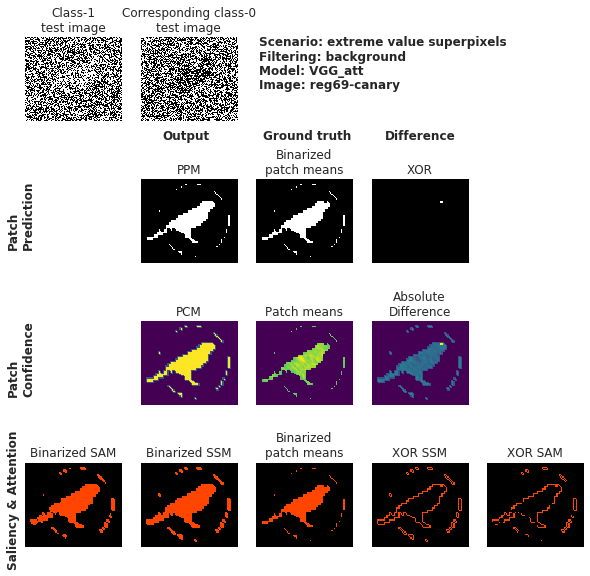

In [18]:
model = "VGG_att"
example_1 = "reg69-canary-hot-test_superpixels.npy"
example_0 = "reg70-canary-cold-test_superpixels.npy"
report_card(scenario, model, example_1, example_0)

# Scenario (e) - Guilty Superpixels (GSP)

### Background-filtered experiments

`Check training labels`

In [19]:
scenario = "guilty_superpixels"
print_train_stats(scenario)

Train dataset
{'reg13': 0, 'reg60': 1, 'reg12': 1, 'reg55': 0, 'reg79': 0, 'reg35': 0, 'reg90': 1, 'reg36': 1, 'reg84': 1, 'reg75': 0, 'reg29': 0, 'reg65': 0, 'reg2': 1, 'reg70': 1, 'reg86': 1, 'reg30': 1, 'reg57': 0, 'reg22': 1, 'reg54': 1, 'reg20': 1, 'reg3': 0, 'reg40': 1, 'reg17': 0, 'reg82': 1, 'reg83': 0, 'reg59': 0, 'reg66': 1, 'reg52': 1, 'reg56': 1, 'reg46': 1, 'reg33': 0, 'reg63': 0, 'reg50': 1, 'reg78': 1, 'reg51': 0, 'reg93': 0, 'reg31': 0, 'reg67': 0, 'reg42': 1, 'reg43': 0, 'reg73': 0, 'reg25': 0, 'reg4': 1, 'reg69': 0, 'reg38': 1, 'reg8': 1, 'reg81': 0, 'reg47': 0, 'reg85': 0, 'reg68': 1, 'reg44': 1, 'reg58': 1, 'reg71': 0, 'reg18': 1, 'reg77': 0, 'reg7': 0, 'reg48': 1, 'reg92': 1, 'reg62': 1, 'reg10': 1, 'reg91': 0, 'reg80': 1, 'reg74': 1, 'reg89': 0, 'reg1': 0, 'reg23': 0, 'reg45': 0, 'reg14': 1, 'reg15': 0, 'reg87': 0, 'reg64': 1, 'reg9': 0, 'reg28': 1, 'reg6': 1, 'reg11': 0, 'reg88': 1, 'reg96': 1, 'reg76': 1, 'reg41': 0, 'reg49': 0, 'reg19': 0, 'reg94': 1, 'reg27': 

`VGG-19 Report Card`

Test dataset:
{'reg3': 0, 'reg45': 0, 'reg24': 1, 'reg31': 0, 'reg54': 1, 'reg79': 0, 'reg85': 0, 'reg65': 0, 'reg9': 0, 'reg88': 1, 'reg90': 1, 'reg73': 0, 'reg60': 1, 'reg50': 1, 'reg42': 1, 'reg27': 0, 'reg70': 1, 'reg34': 1, 'reg22': 1, 'reg91': 0, 'reg63': 0, 'reg46': 1, 'reg77': 0, 'reg81': 0, 'reg21': 0, 'reg35': 0, 'reg16': 1, 'reg20': 1, 'reg23': 0, 'reg49': 0, 'reg86': 1, 'reg74': 1, 'reg83': 0, 'reg62': 1, 'reg56': 1, 'reg52': 1, 'reg2': 1, 'reg30': 1, 'reg17': 0, 'reg28': 1, 'reg76': 1, 'reg61': 0, 'reg5': 0, 'reg14': 1, 'reg19': 0, 'reg64': 1, 'reg67': 0, 'reg32': 1, 'reg38': 1, 'reg55': 0, 'reg57': 0, 'reg18': 1, 'reg59': 0, 'reg36': 1, 'reg40': 1, 'reg6': 1, 'reg75': 0, 'reg95': 0, 'reg15': 0, 'reg87': 0, 'reg13': 0, 'reg72': 1, 'reg47': 0, 'reg12': 1, 'reg71': 0, 'reg84': 1, 'reg26': 1, 'reg39': 0, 'reg48': 1, 'reg66': 1, 'reg25': 0, 'reg93': 0, 'reg89': 0, 'reg58': 1, 'reg4': 1, 'reg44': 1, 'reg10': 1, 'reg33': 0, 'reg7': 0, 'reg29': 0, 'reg1': 0, 'reg92': 1, 'reg37': 

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 18 reg22 label= 1
	 19 reg91 label= 0
	 20 reg63 label= 0
	Completed analyses for 20 control images
	 21 reg46 label= 1
	 22 reg77 label= 0
	 23 reg81 label= 0
	 24 reg21 label= 0
	 25 reg35 label= 0
	 26 reg16 label= 1
	 27 reg20 label= 1
	 28 reg23 label= 0
	 29 reg49 label= 0
	 30 reg86 label= 1
	Completed analyses for 30 control images
	 31 reg74 label= 1
	 32 reg83 label= 0
	 33 reg62 label= 1
	 34 reg56 label= 1
	 35 reg52 label= 1
	 36 reg2 label= 1
	 37 reg30 label= 1
	 38 reg17 label= 0
	 39 reg28 label= 1
	 40 reg76 label= 1
	Completed analyses for 40 control images
	 41 reg61 label= 0
	 42 reg5 label= 0
	 43 reg14 label= 1
	 44 reg19 label= 0
	 45 reg64 label= 1
	 46 reg67 label= 0
	 47 reg32 label= 1
	 48 reg38 label= 1
	 49 reg55 label= 0
	 50 reg57 label= 0
	Completed analyses for 50 control images
	 51 reg18 label= 1
	 52 reg59 label= 0
	 53 reg36 label= 1
	 54 reg40 label= 1
	 55 reg6 label= 1
	 56 reg75 label= 0
	 57 reg95 label= 0
	 58 reg15 label= 0
	 59 reg87 labe

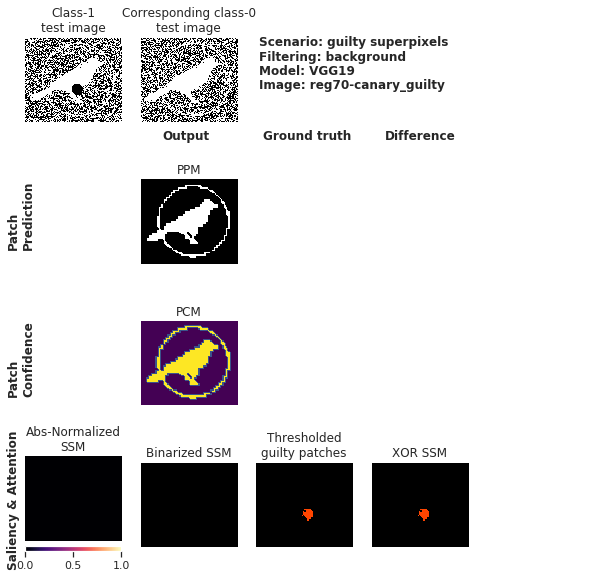

In [20]:
model = "VGG19"
example_1 = "reg70-canary_guilty-hot-test.npy" # "reg2-jerrywest-logodesignlove_guilty-hot-test.npy" 
example_0 =  "reg69-canary-hot-test.npy" # "reg1-jerrywest-logodesignlove-hot-test.npy"
report_card(scenario, model, example_1, example_0, reduce_flag="manual")

`VGG-Att Report Card`

Test dataset:
{'reg3': 0, 'reg45': 0, 'reg24': 1, 'reg31': 0, 'reg54': 1, 'reg79': 0, 'reg85': 0, 'reg65': 0, 'reg9': 0, 'reg88': 1, 'reg90': 1, 'reg73': 0, 'reg60': 1, 'reg50': 1, 'reg42': 1, 'reg27': 0, 'reg70': 1, 'reg34': 1, 'reg22': 1, 'reg91': 0, 'reg63': 0, 'reg46': 1, 'reg77': 0, 'reg81': 0, 'reg21': 0, 'reg35': 0, 'reg16': 1, 'reg20': 1, 'reg23': 0, 'reg49': 0, 'reg86': 1, 'reg74': 1, 'reg83': 0, 'reg62': 1, 'reg56': 1, 'reg52': 1, 'reg2': 1, 'reg30': 1, 'reg17': 0, 'reg28': 1, 'reg76': 1, 'reg61': 0, 'reg5': 0, 'reg14': 1, 'reg19': 0, 'reg64': 1, 'reg67': 0, 'reg32': 1, 'reg38': 1, 'reg55': 0, 'reg57': 0, 'reg18': 1, 'reg59': 0, 'reg36': 1, 'reg40': 1, 'reg6': 1, 'reg75': 0, 'reg95': 0, 'reg15': 0, 'reg87': 0, 'reg13': 0, 'reg72': 1, 'reg47': 0, 'reg12': 1, 'reg71': 0, 'reg84': 1, 'reg26': 1, 'reg39': 0, 'reg48': 1, 'reg66': 1, 'reg25': 0, 'reg93': 0, 'reg89': 0, 'reg58': 1, 'reg4': 1, 'reg44': 1, 'reg10': 1, 'reg33': 0, 'reg7': 0, 'reg29': 0, 'reg1': 0, 'reg92': 1, 'reg37': 

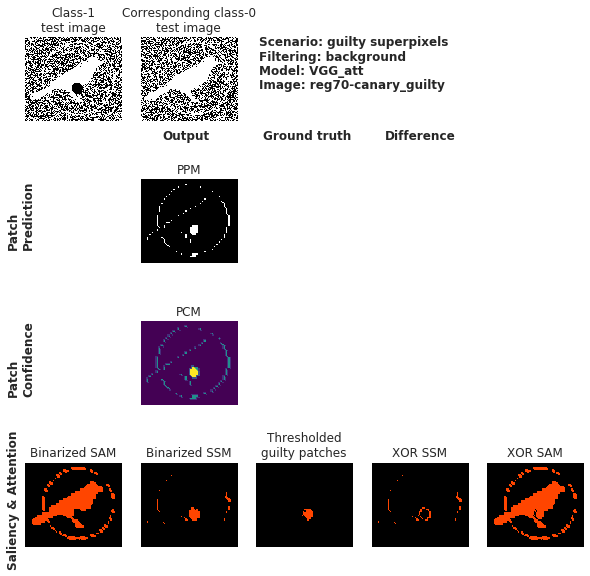

In [21]:
model = "VGG_att"
example_1 = "reg70-canary_guilty-hot-test.npy" # "reg2-jerrywest-logodesignlove_guilty-hot-test.npy" 
example_0 = "reg69-canary-hot-test.npy" # "reg1-jerrywest-logodesignlove-hot-test.npy"
report_card(scenario, model, example_1, example_0, reduce_flag="manual")

# Scenario (g) - Fractal Morphologies (FM)

### Background-filtered experiments

`Check training labels`

In [22]:
scenario = "fractal_morphologies"
print_train_stats(scenario)

Train dataset
{'reg32': 1, 'reg13': 0, 'reg10': 1, 'reg64': 1, 'reg16': 1, 'reg55': 0, 'reg79': 0, 'reg35': 0, 'reg6': 1, 'reg22': 1, 'reg75': 0, 'reg29': 0, 'reg65': 0, 'reg42': 1, 'reg96': 1, 'reg8': 1, 'reg57': 0, 'reg74': 1, 'reg3': 0, 'reg17': 0, 'reg83': 0, 'reg78': 1, 'reg66': 1, 'reg59': 0, 'reg48': 1, 'reg2': 1, 'reg33': 0, 'reg63': 0, 'reg51': 0, 'reg93': 0, 'reg31': 0, 'reg90': 1, 'reg67': 0, 'reg92': 1, 'reg43': 0, 'reg73': 0, 'reg28': 1, 'reg25': 0, 'reg84': 1, 'reg69': 0, 'reg70': 1, 'reg24': 1, 'reg81': 0, 'reg72': 1, 'reg47': 0, 'reg85': 0, 'reg71': 0, 'reg12': 1, 'reg77': 0, 'reg86': 1, 'reg30': 1, 'reg62': 1, 'reg7': 0, 'reg91': 0, 'reg94': 1, 'reg89': 0, 'reg60': 1, 'reg1': 0, 'reg23': 0, 'reg52': 1, 'reg45': 0, 'reg15': 0, 'reg87': 0, 'reg68': 1, 'reg50': 1, 'reg9': 0, 'reg11': 0, 'reg58': 1, 'reg76': 1, 'reg20': 1, 'reg41': 0, 'reg49': 0, 'reg19': 0, 'reg46': 1, 'reg27': 0, 'reg5': 0, 'reg40': 1, 'reg18': 1, 'reg54': 1, 'reg56': 1, 'reg39': 0, 'reg14': 1, 'reg37': 

`VGG-19 Report Card`

Test dataset:
{'reg3': 0, 'reg45': 0, 'reg31': 0, 'reg66': 1, 'reg30': 1, 'reg92': 1, 'reg79': 0, 'reg85': 0, 'reg65': 0, 'reg9': 0, 'reg73': 0, 'reg27': 0, 'reg38': 1, 'reg91': 0, 'reg63': 0, 'reg77': 0, 'reg34': 1, 'reg81': 0, 'reg21': 0, 'reg22': 1, 'reg20': 1, 'reg2': 1, 'reg80': 1, 'reg24': 1, 'reg35': 0, 'reg42': 1, 'reg56': 1, 'reg23': 0, 'reg50': 1, 'reg49': 0, 'reg94': 1, 'reg70': 1, 'reg14': 1, 'reg83': 0, 'reg96': 1, 'reg17': 0, 'reg61': 0, 'reg54': 1, 'reg90': 1, 'reg46': 1, 'reg5': 0, 'reg19': 0, 'reg78': 1, 'reg67': 0, 'reg84': 1, 'reg12': 1, 'reg32': 1, 'reg10': 1, 'reg55': 0, 'reg28': 1, 'reg57': 0, 'reg59': 0, 'reg52': 1, 'reg75': 0, 'reg64': 1, 'reg8': 1, 'reg95': 0, 'reg15': 0, 'reg44': 1, 'reg48': 1, 'reg58': 1, 'reg87': 0, 'reg13': 0, 'reg47': 0, 'reg36': 1, 'reg71': 0, 'reg62': 1, 'reg40': 1, 'reg74': 1, 'reg39': 0, 'reg4': 1, 'reg25': 0, 'reg93': 0, 'reg89': 0, 'reg16': 1, 'reg76': 1, 'reg18': 1, 'reg6': 1, 'reg33': 0, 'reg7': 0, 'reg29': 0, 'reg1': 0, 'reg86': 1

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:653: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 33 reg83 label= 0
	 34 reg96 label= 1
	 35 reg17 label= 0
	 36 reg61 label= 0
	 37 reg54 label= 1
	 38 reg90 label= 1
	 39 reg46 label= 1
	 40 reg5 label= 0
	Completed analyses for 40 control images
	 41 reg19 label= 0
	 42 reg78 label= 1
	 43 reg67 label= 0
	 44 reg84 label= 1
	 45 reg12 label= 1
	 46 reg32 label= 1
	 47 reg10 label= 1
	 48 reg55 label= 0
	 49 reg28 label= 1
	 50 reg57 label= 0
	Completed analyses for 50 control images
	 51 reg59 label= 0
	 52 reg52 label= 1
	 53 reg75 label= 0
	 54 reg64 label= 1
	 55 reg8 label= 1
	 56 reg95 label= 0
	 57 reg15 label= 0
	 58 reg44 label= 1
	 59 reg48 label= 1
	 60 reg58 label= 1
	Completed analyses for 60 control images
	 61 reg87 label= 0
	 62 reg13 label= 0
	 63 reg47 label= 0
	 64 reg36 label= 1
	 65 reg71 label= 0
	 66 reg62 label= 1
	 67 reg40 label= 1
	 68 reg74 label= 1
	 69 reg39 label= 0
	 70 reg4 label= 1
	Completed analyses for 70 control images
	 71 reg25 label= 0
	 72 reg93 label= 0
	 73 reg89 label= 0
	 74 reg16 labe

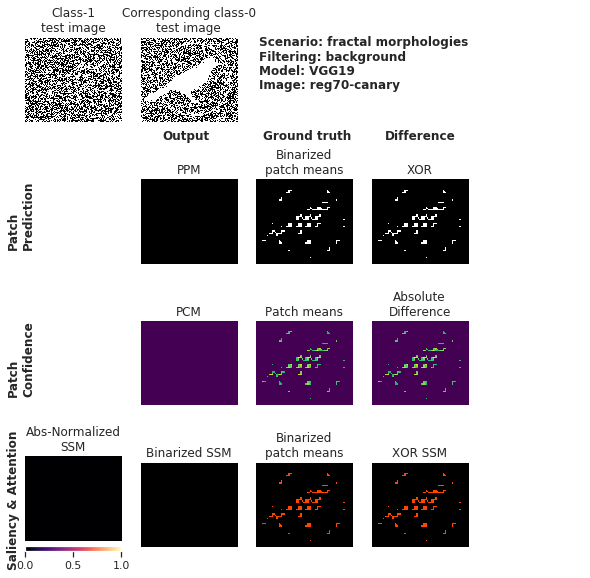

In [23]:
model = "VGG19"
example_1 = "reg70-canary-hot-test_fractal.npy" 
example_0 = "reg69-canary-hot-test.npy"
report_card(scenario, model, example_1, example_0)

`VGG-Att Report Card`

Test dataset:
{'reg3': 0, 'reg45': 0, 'reg31': 0, 'reg66': 1, 'reg30': 1, 'reg92': 1, 'reg79': 0, 'reg85': 0, 'reg65': 0, 'reg9': 0, 'reg73': 0, 'reg27': 0, 'reg38': 1, 'reg91': 0, 'reg63': 0, 'reg77': 0, 'reg34': 1, 'reg81': 0, 'reg21': 0, 'reg22': 1, 'reg20': 1, 'reg2': 1, 'reg80': 1, 'reg24': 1, 'reg35': 0, 'reg42': 1, 'reg56': 1, 'reg23': 0, 'reg50': 1, 'reg49': 0, 'reg94': 1, 'reg70': 1, 'reg14': 1, 'reg83': 0, 'reg96': 1, 'reg17': 0, 'reg61': 0, 'reg54': 1, 'reg90': 1, 'reg46': 1, 'reg5': 0, 'reg19': 0, 'reg78': 1, 'reg67': 0, 'reg84': 1, 'reg12': 1, 'reg32': 1, 'reg10': 1, 'reg55': 0, 'reg28': 1, 'reg57': 0, 'reg59': 0, 'reg52': 1, 'reg75': 0, 'reg64': 1, 'reg8': 1, 'reg95': 0, 'reg15': 0, 'reg44': 1, 'reg48': 1, 'reg58': 1, 'reg87': 0, 'reg13': 0, 'reg47': 0, 'reg36': 1, 'reg71': 0, 'reg62': 1, 'reg40': 1, 'reg74': 1, 'reg39': 0, 'reg4': 1, 'reg25': 0, 'reg93': 0, 'reg89': 0, 'reg16': 1, 'reg76': 1, 'reg18': 1, 'reg6': 1, 'reg33': 0, 'reg7': 0, 'reg29': 0, 'reg1': 0, 'reg86': 1

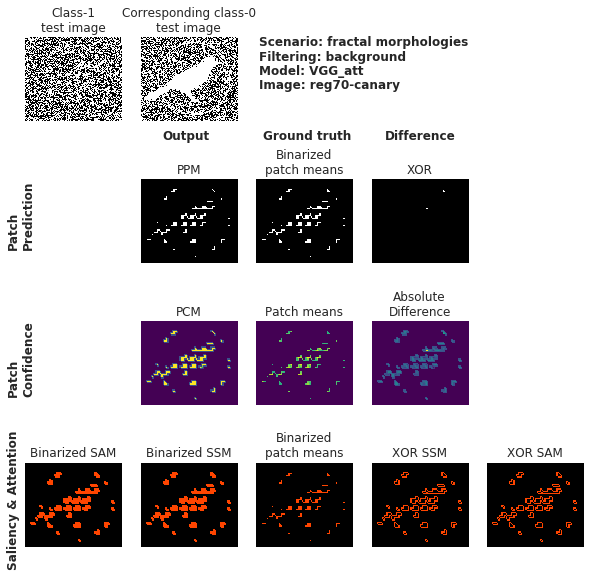

In [24]:
model = "VGG_att"
example_1 = "reg70-canary-hot-test_fractal.npy" 
example_0 = "reg69-canary-hot-test.npy"
report_card(scenario, model, example_1, example_0)